In [1]:
import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os #システム操作系
from pathlib import Path #ファイル操作系
from createdatas3 import intensity, gaussian_beam
from scipy.optimize import curve_fit    # フィッティング用
from scipy.stats import norm
import time
import pickle

dt_now = datetime.datetime.now()
print('現在時刻：', dt_now)

現在時刻： 2020-12-11 21:28:29.098083


In [2]:
# このファイルの存在するフォルダの絶対パスを取得
dir_name = str(Path().resolve())
print('このファイルの存在するフォルダ：', dir_name)

# 保存先フォルダのパス作成
save_folder = os.path.join(dir_name, '201211')
print('保存フォルダ：', save_folder)

# 保存先フォルダの作成(既に存在する場合は無視される)
os.makedirs(save_folder, exist_ok=True)

このファイルの存在するフォルダ： /Users/nagaiyuma/Documents/myprogram
保存フォルダ： /Users/nagaiyuma/Documents/myprogram/201211


In [3]:
# グラフの初期設定
plt.rcParams["figure.figsize"] = [3.14, 3.14] # 図の縦横のサイズ([横(inch),縦(inch)])
plt.rcParams["figure.dpi"] = 200 # dpi(dots per inch)
plt.rcParams["figure.facecolor"] = 'white' # 図の背景色
plt.rcParams["figure.edgecolor"] = 'black' # 枠線の色
plt.rcParams["font.family"] = "serif"       # 使用するフォント
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 14              # 基本となるフォントの大きさ

plt.rcParams["xtick.direction"] = "in"      # 目盛り線の向き、内側"in"か外側"out"かその両方"inout"か
plt.rcParams["ytick.direction"] = "in"      # 目盛り線の向き、内側"in"か外側"out"かその両方"inout"か
plt.rcParams["xtick.bottom"] = True         # 下部に目盛り線を描くかどうか
plt.rcParams["ytick.left"] = True           # 左部に目盛り線を描くかどうか
plt.rcParams["xtick.major.size"] = 2.0      # x軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 2.0      # y軸主目盛り線の長さ
plt.rcParams["xtick.major.width"] = 0.3     # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 0.3     # y軸主目盛り線の線幅
plt.rcParams["xtick.minor.visible"] = False # x軸副目盛り線を描くかどうか
plt.rcParams["ytick.minor.visible"] = False # y軸副目盛り線を描くかどうか
plt.rcParams["xtick.minor.size"] = 2.0      # x軸副目盛り線の長さ
plt.rcParams["ytick.minor.size"] = 2.0      # y軸副目盛り線の長さ
plt.rcParams["xtick.minor.width"] = 0.3     # x軸副目盛り線の線幅
plt.rcParams["ytick.minor.width"] = 0.3     # y軸副目盛り線の線幅
plt.rcParams["xtick.labelsize"] = 8        # 目盛りのフォントサイズ
plt.rcParams["ytick.labelsize"] = 8        # 目盛りのフォントサイズ
plt.rcParams["xtick.major.pad"] = 3.0      # x軸から目盛までの距離
plt.rcParams["ytick.major.pad"] = 4.0      # y軸から目盛までの距離

plt.rcParams["axes.labelsize"] = 10         # 軸ラベルのフォントサイズ
plt.rcParams["axes.linewidth"] = 0.4        # グラフ囲う線の太さ
plt.rcParams["axes.grid"] = False           # グリッドを表示するかどうか

In [4]:
#フィッティングパラメータ取得
data_param_path = '/Users/nagaiyuma/Documents/myprogram/201209/2020-12-10_15-19_fit-param.pkl'
with open(data_param_path, mode="rb") as f:
    param = pickle.load(f)

print(param)

[ 9.28827417e-01 -1.07953945e-01  5.97782015e+02  4.59929242e+02
  5.75242649e+01  5.69547526e+01  5.18587130e-02]


In [5]:
#訓練データ作成
N = 50 #訓練データの個数

def gaussian_beam_xy(X,i0,b0,x0,y0,wx,wy,h0):
    x,y = X
    return  (i0*np.exp((-2/(1-b0**2))*(((x-x0)/wx)**2+((y-y0)/wy)**2-2*b0*((x-x0)/wx)*((y-y0)/wy)))+ h0).flatten()
#中心位置
idx = np.zeros((2, N))
idx[0] = idx[0]-0.5
idx = idx.T

#画像サイズ
size = 100
x_array = np.arange(0, size*2, 1.0)                         # x配列
y_array = np.arange(0, size*2, 1.0)                         # y配列
nx = len(x_array)
ny = len(y_array)
x_grid, y_grid = np.meshgrid(x_array, y_array)
intensity = np.zeros((N,nx,ny))
idx = idx + size #中心に持ってくる
start = time.time()
for n in range(N):
    #初期パラメータ
    i0 = param[0]
    b0 = param[1]
    x0 = idx[n][0]
    y0 = idx[n][1]
    wx = param[4]
    wy = param[5]
    h0 = param[6]
    param = np.array([i0, b0, x0, y0, wx, wy, h0])  #初期値
    
    #強度の計算
    intensity[n] = gaussian_beam_xy((x_grid.T, y_grid.T), *param).reshape(nx,ny)
intensity = intensity.reshape(N,nx*ny)
intensity_noise = np.zeros((N, nx, ny))
NOISE = np.zeros((N, nx*ny))

for k in range(nx*ny): 
    NOISE[:,k] = (np.random.normal(loc=0,scale=0.00844*intensity[0][k]+0.00165,size=int(N)))

intensity_noise = intensity.reshape(N,nx,ny) + NOISE.reshape(N,nx,ny)

elapsed_time = time.time() - start
print ("経過時間:{0}".format(elapsed_time) + "[sec]")

経過時間:0.7822401523590088[sec]


In [6]:
ave_norm = np.average(intensity_noise, axis=0)
print(ave_norm.shape)

(200, 200)


(200, 200)


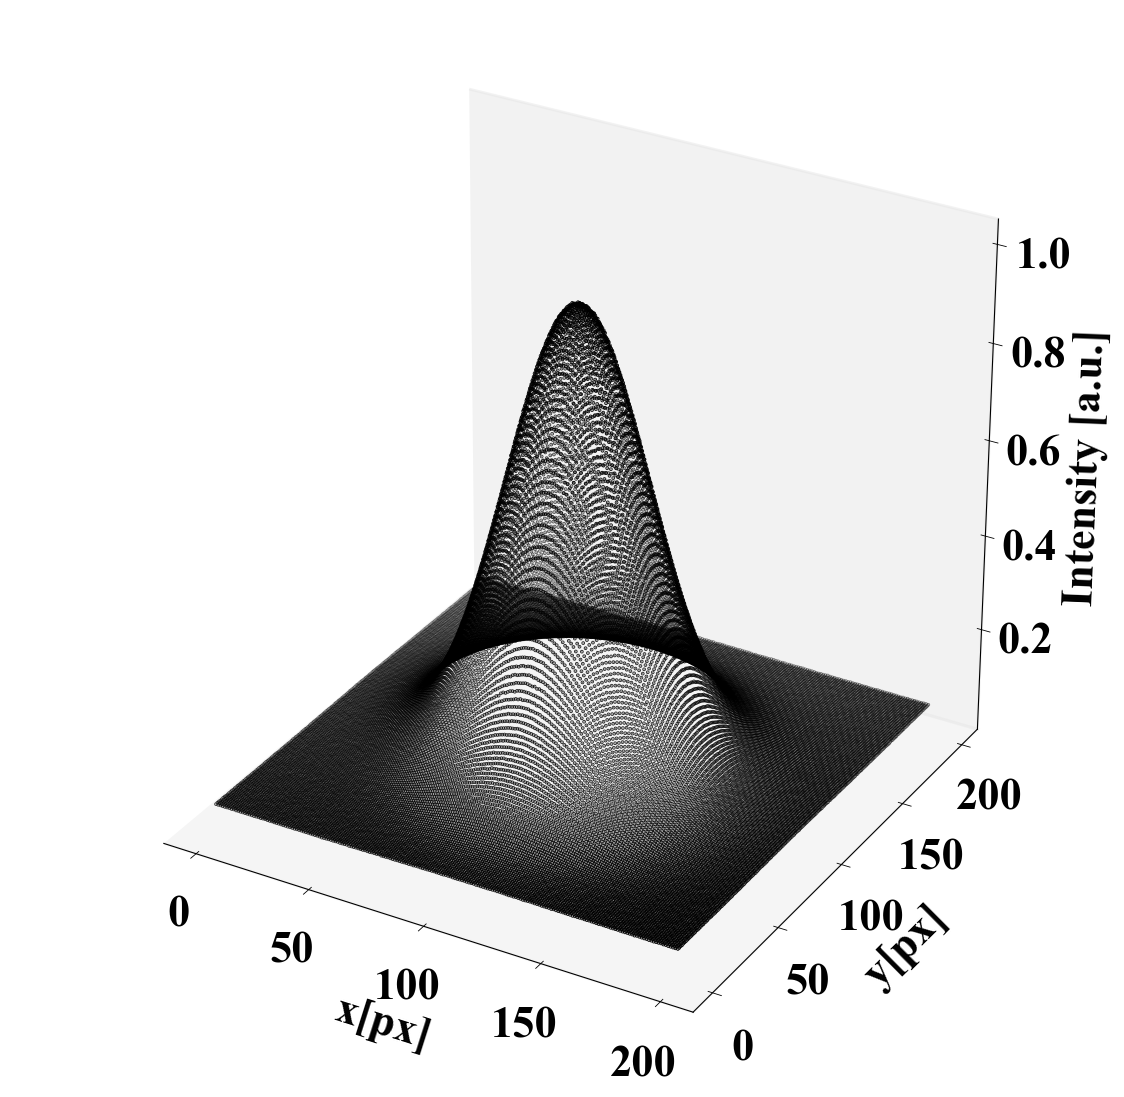

保存ファイル名： 2020-12-11_21-28_ave_norm-50.png
保存ファイルパス： /Users/nagaiyuma/Documents/myprogram/201211/2020-12-11_21-28_ave_norm-50.png


In [7]:
#50回精算norm

print(ave_norm.shape)
save_name = dt_now.strftime("%Y-%m-%d_%H-%M") +'_ave_norm-50.png'
save_file = os.path.join(save_folder, save_name) # 保存先のファイルパス作成

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x[px]", fontsize=16)
ax.set_ylabel("y[px]", fontsize=16)
ax.set_zlabel("Intensity [a.u.]", fontsize=16)
plt.tick_params(labelsize=16)
ax.grid(False)
ax.scatter(x_grid.T, y_grid.T, ave_norm, color='black', s=0.1)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#fig.savefig(save_file, format="png", bbox_inches="tight")
plt.show()
print('保存ファイル名：', save_name)
print('保存ファイルパス：', save_file)

In [8]:
#2D楕円ガウシアンビームの関数の定義
def gaussian_beam_xy(X,i0,b0,x0,y0,wx,wy,h0):
    x,y = X
    return  (i0*np.exp((-2/(1-b0**2))*(((x-x0)/wx)**2+((y-y0)/wy)**2-2*b0*((x-x0)/wx)*((y-y0)/wy)))+ h0).flatten()
idx_fit = np.unravel_index(np.argmax(ave_norm), ave_norm.shape)
print(idx_fit)
#初期パラメータ
i0 = 1.0
b0 = 0.5
x0 = idx_fit[0]
y0 = idx_fit[1]
wx = 50.0
wy = 50.0
h0 = 0.0
ave_norm = ave_norm.flatten()
param_ini = np.array([i0, b0, x0, y0, wx, wy, h0])
param, cov  = curve_fit(gaussian_beam_xy, (x_grid.T, y_grid.T), ave_norm, p0=param_ini, maxfev=2000)
intensity_fit_xy = gaussian_beam_xy((x_grid.T, y_grid.T), *param)
#結果の表示
print(f'ガウスparam: {param}')

(99, 101)
ガウスparam: [ 9.28859843e-01 -1.07973532e-01  9.94994902e+01  1.00000474e+02
  5.75223808e+01  5.69523481e+01  5.18610864e-02]


NameError: name 'ave' is not defined

In [9]:
error = (ave_norm.flatten() - intensity_fit_xy.flatten()).reshape(nx,ny)
std_error = np.std(error)
ave_error = np.average(error)
print(f'残差:{ave_error}±{std_error}')

残差:3.090382064835362e-14±0.0004975704031419534


平均残差:3.090382064835362e-14±0.0004975704031419534


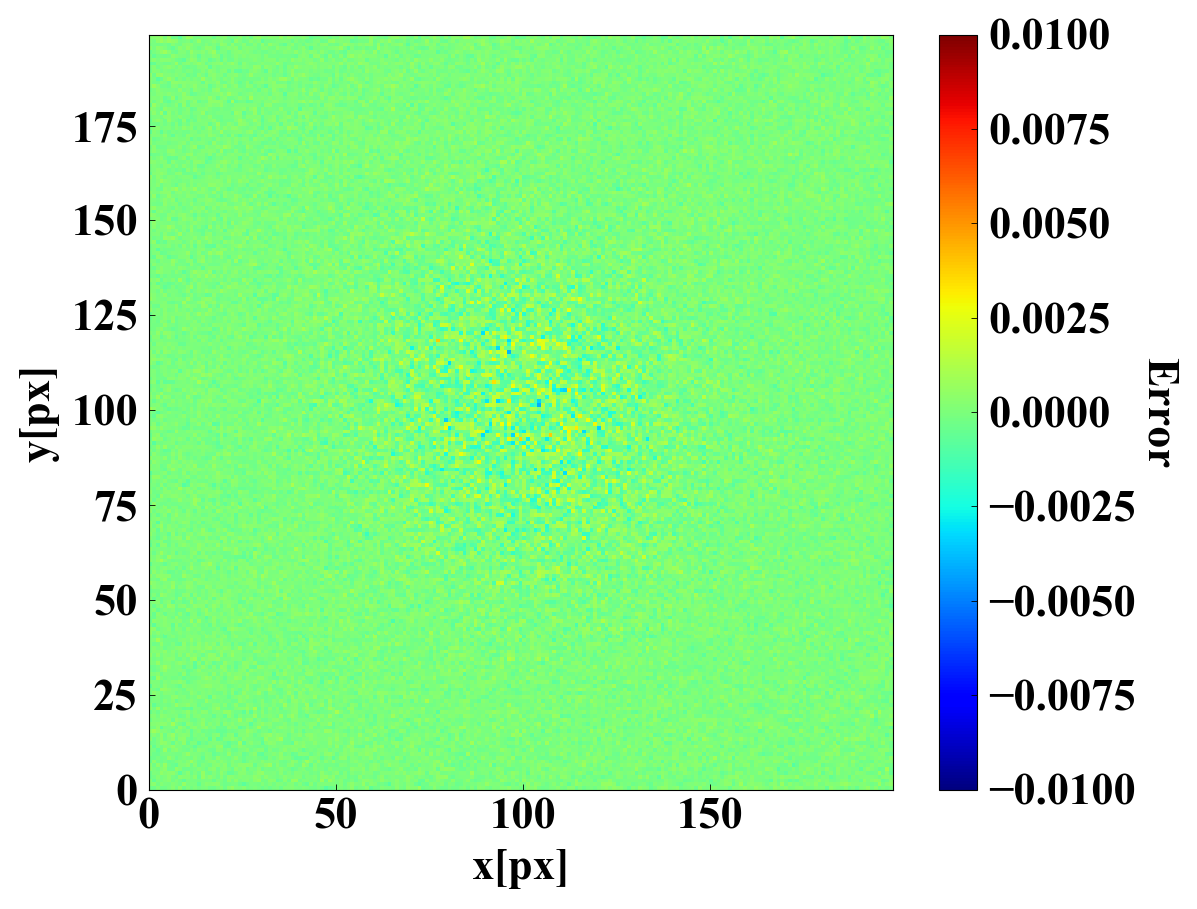

保存ファイル名： 2020-12-11_21-28_error-ave50cmap.png
保存ファイルパス： /Users/nagaiyuma/Documents/myprogram/201211/2020-12-11_21-28_error-ave50cmap.png


In [14]:
#残差の計算
error = (ave_norm.flatten() - intensity_fit_xy.flatten()).reshape(nx,ny)
std_noise = np.std(error)
ave_noise = np.average(error)
print(f'平均残差:{ave_noise}±{std_noise}')
#残差の表示
save_name = dt_now.strftime("%Y-%m-%d_%H-%M") +'_error-ave50cmap.png'
save_file = os.path.join(save_folder, save_name) # 保存先のファイルパス作成
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.set_xlabel("x[px]", fontsize=16)
ax.set_ylabel("y[px]", fontsize=16)
ax.tick_params(labelsize=16)
mappable = ax.pcolormesh(x_grid.T, y_grid.T, error, cmap='jet', vmin=-0.01, vmax=0.01)
cbar = fig.colorbar(mappable, ax=ax)
cbar.set_label("Error", fontsize=16,rotation=270,labelpad = 15)
cbar.ax.tick_params(labelsize=16)
fig.savefig(save_file, format="png", bbox_inches="tight")
plt.show()
print('保存ファイル名：', save_name)
print('保存ファイルパス：', save_file)

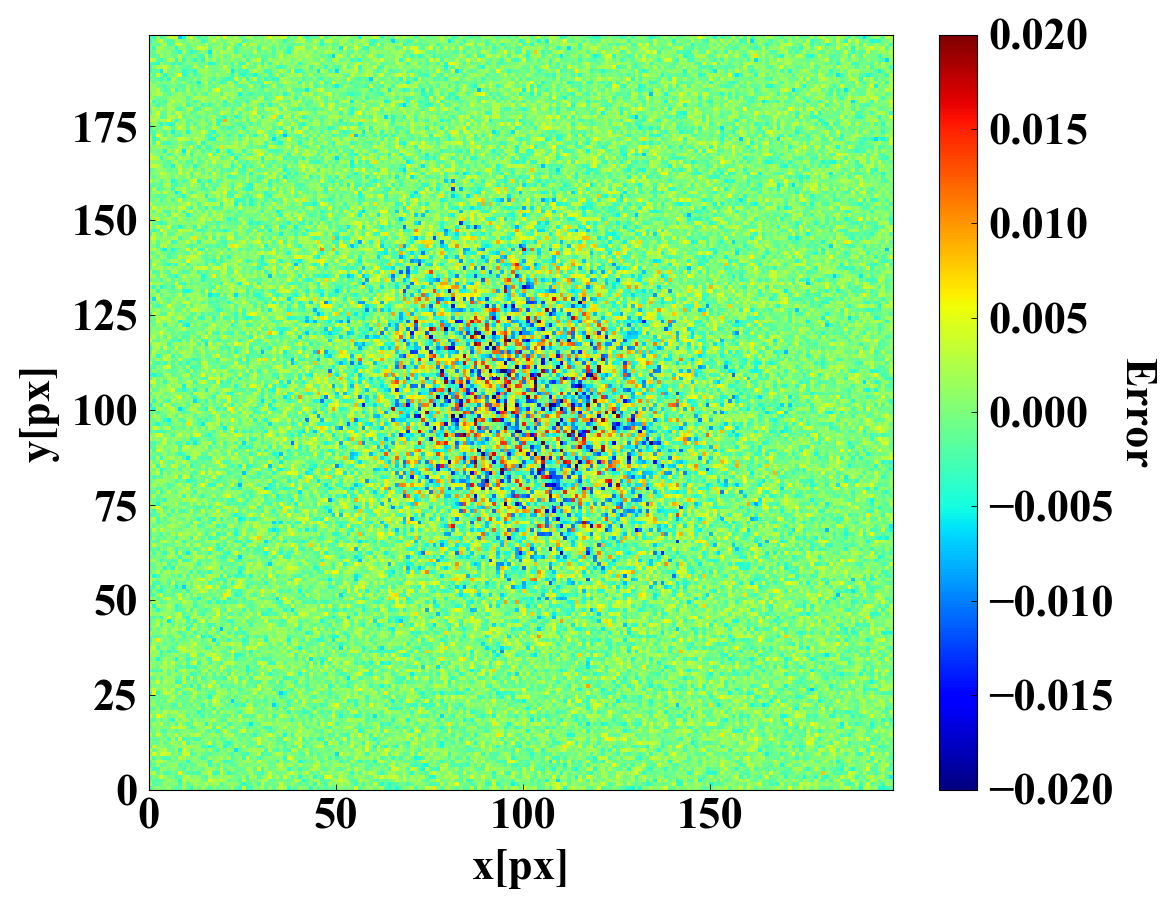

保存ファイル名： 2020-12-11_21-28_jet_noise-norm.png
保存ファイルパス： /Users/nagaiyuma/Documents/myprogram/201211/2020-12-11_21-28_jet_noise-norm.png


In [23]:
#加算したノイズの表示
NOISE_norm = NOISE.reshape(N, nx, ny)[0]
save_name = dt_now.strftime("%Y-%m-%d_%H-%M") +'_jet_noise-norm.png'
save_file = os.path.join(save_folder, save_name) # 保存先のファイルパス作成
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.set_xlabel("x[px]", fontsize=16)
ax.set_ylabel("y[px]", fontsize=16)
ax.tick_params(labelsize=16)
mappable = ax.pcolormesh(x_grid.T, y_grid.T, NOISE_norm, cmap='jet', vmin=-0.02, vmax=0.02)
cbar = fig.colorbar(mappable, ax=ax)
cbar.set_label("Error", fontsize=16,rotation=270,labelpad = 15)
cbar.ax.tick_params(labelsize=16)
fig.savefig(save_file, format="png", bbox_inches="tight")
plt.show()
print('保存ファイル名：', save_name)
print('保存ファイルパス：', save_file)

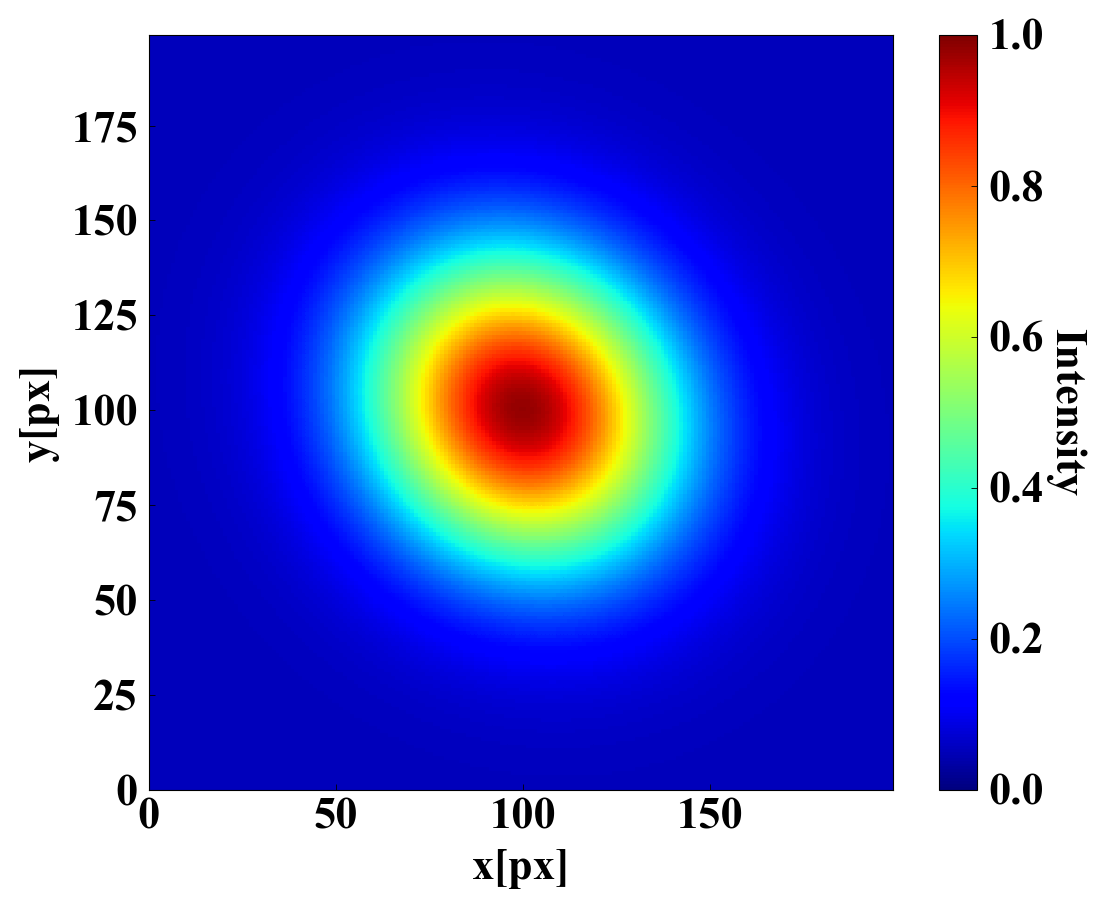

保存ファイル名： 2020-12-11_21-28_jet_intensity.png
保存ファイルパス： /Users/nagaiyuma/Documents/myprogram/201211/2020-12-11_21-28_jet_intensity.png


In [21]:
#加算したノイズの表示
NOISE_norm = intensity.reshape(N, nx, ny)[0]
save_name = dt_now.strftime("%Y-%m-%d_%H-%M") +'_jet_intensity.png'
save_file = os.path.join(save_folder, save_name) # 保存先のファイルパス作成
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.set_xlabel("x[px]", fontsize=16)
ax.set_ylabel("y[px]", fontsize=16)
ax.tick_params(labelsize=16)
mappable = ax.pcolormesh(x_grid.T, y_grid.T, NOISE_norm, cmap='jet', vmin=0.0, vmax=1.0)
cbar = fig.colorbar(mappable, ax=ax)
cbar.set_label("Intensity", fontsize=16,rotation=270,labelpad = 15)
cbar.ax.tick_params(labelsize=16)
fig.savefig(save_file, format="png", bbox_inches="tight")
plt.show()
print('保存ファイル名：', save_name)
print('保存ファイルパス：', save_file)

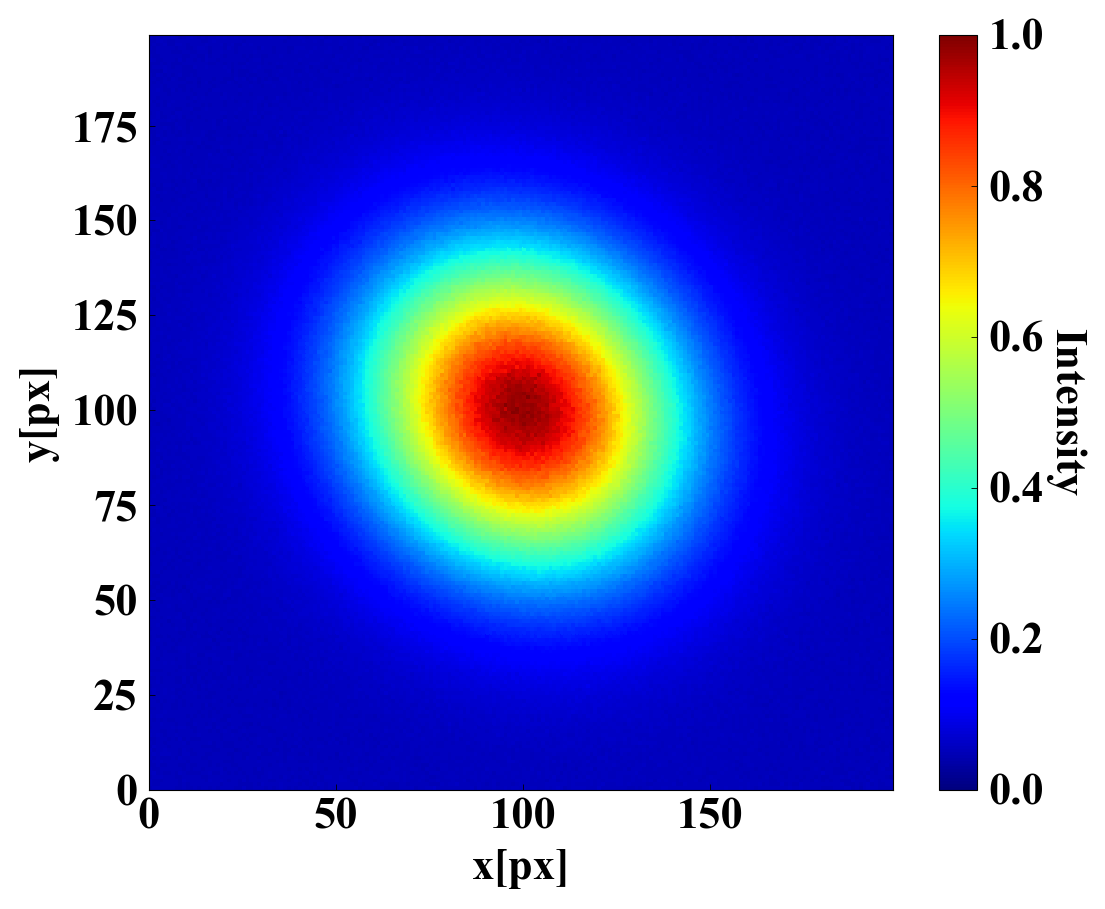

保存ファイル名： 2020-12-11_21-28_jet_intensity+noise.png
保存ファイルパス： /Users/nagaiyuma/Documents/myprogram/201211/2020-12-11_21-28_jet_intensity+noise.png


In [22]:
#加算したノイズの表示
NOISE_norm = intensity_noise.reshape(N, nx, ny)[0]
save_name = dt_now.strftime("%Y-%m-%d_%H-%M") +'_jet_intensity+noise.png'
save_file = os.path.join(save_folder, save_name) # 保存先のファイルパス作成
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.set_xlabel("x[px]", fontsize=16)
ax.set_ylabel("y[px]", fontsize=16)
ax.tick_params(labelsize=16)
mappable = ax.pcolormesh(x_grid.T, y_grid.T, NOISE_norm, cmap='jet', vmin=0.0, vmax=1.0)
cbar = fig.colorbar(mappable, ax=ax)
cbar.set_label("Intensity", fontsize=16,rotation=270,labelpad = 15)
cbar.ax.tick_params(labelsize=16)
fig.savefig(save_file, format="png", bbox_inches="tight")
plt.show()
print('保存ファイル名：', save_name)
print('保存ファイルパス：', save_file)